# Import all the required modules like numpy,tensorflow,cv2,pil

In [1]:
import PIL
from PIL import Image
import numpy as np
import random
import os
import fnmatch
import cv2
from PIL import ImageFile
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
#from PIL import Image, ImageFile
from sklearn.cluster import KMeans
import pickle
import imagehash
from IPython.display import Image

# Define current directory , data directory

In [2]:
current_directory = os.getcwd()
main_dir = '/home/Documents'
data_dir = current_directory + '/image_data'
valid_dir = current_directory + '/valid_set'

# Add gaussian blur to image,flip image, translate image and rotate image

In [ ]:
def apply_blur(image_name,newname):
    #kernel=np.ones(5,5)/25.0
    #blurred=np.zeros_like(image)
    #cv2.filter2D(image,-1,kernel,dst) #applying mean blur
    image = Image.open(image_name)
    blurred=gaussian_filter(image,sigma=50) #applies gausian blur
    cv2.imwrite(newname,blurred)

In [ ]:
%cd $main_dir/valid_set

In [ ]:
apply_blur('White.jpeg','white_blur_40.jpeg')

## Flipped image

In [ ]:
img = Image.open('pp.jpeg')
flipped = np.fliplr(img)
cv2.imwrite('pp_flip.jpeg',cv2.cvtColor(flipped,cv2.COLOR_RGB2BGR))

## Translate image

In [ ]:
img = Image.new('RGB', (10, 10), 'blue')
a = 1
b = 0
c = 50#left/right (i.e. 50)
d = 0
e = 1
f = 50 #up/down (i.e. 50)
img = Image.open('White.jpeg')
img = img.transform(img.size, Image.AFFINE, (a, b, c, d, e, f))
img.save('white_translated_50.jpeg')

## Rotate image

In [ ]:
#rotation angle in degree
image = cv2.imread('black1.jpeg')
rotated = ndimage.rotate(image, 180)
cv2.imwrite('black_rotated_180.jpeg',rotated)

# Fetch all the jpegs from the data directory

In [3]:
path = '/home/Documents/image_data/'

configfiles = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(path)
    for f in fnmatch.filter(files, '*.jpeg')]

# Preprocess the data by resize, converting into an array and rescale the image and define the get_batch function

In [4]:
def resize(img, output_shape = (32, 32)):
     return img.resize(output_shape, PIL.Image.ANTIALIAS)
        #return cv2.resize(img, output_shape) 

In [5]:
def rescale(A, method=1):
    if 1== method:  
        return A / float(A.max())

In [6]:
def img2array(img, dtype=np.float32):
    return np.array(img, dtype=dtype)

In [7]:
def get_batch(configfiles,ibatch, batch_size=100):    
    
    ibatch = ibatch % len(configfiles)
    
    image_name_list_batch = configfiles[ibatch:ibatch+batch_size]
    
       # print(image_name_list_batch)
    import PIL.Image     
    
    img_data_list = []
    for image_name in image_name_list_batch:
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        img = PIL.Image.open(image_name)
        img = resize(img)
        img_data_list += [rescale( img2array(img) )]
        
    X_batch = np.asanyarray(img_data_list)
    return (X_batch)

# CNN Auto Encoder Decoder Model

In [9]:
#learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32,[None,32,32,3])
targets_ = tf.placeholder(tf.float32,[None,32,32,3])

In [10]:
def lrelu(x,alpha=0.1):
    return tf.maximum(alpha*x,x)

## Encoder

In [11]:
### Encoder
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(inputs_,filters=4,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv1')
# Now 32x32x4
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=(2,2),strides=(2,2),name='pool1')
# Now 16x16x4
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,filters=8,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv2')
# Now 16x16x8
with tf.name_scope('en-pooling'):
    maxpool2 = tf.layers.max_pooling2d(conv2,pool_size=(2,2),strides=(2,2),name='pool2')
# Now 8x8x8
with tf.name_scope('en-convolutions'):
    conv3 = tf.layers.conv2d(maxpool2,filters=16,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv3')
# Now 8x8x16
with tf.name_scope('encoding'):
    encoded = tf.layers.average_pooling2d(conv3,pool_size=(2,2),strides=(2,2),name='encoding')
# Now 4x4x16.
#latent space

## Decoder

In [12]:
### Decoder
with tf.name_scope('decoder'):
    upsample1 = tf.layers.conv2d_transpose(encoded,filters=16,kernel_size=3,padding='same',strides=2,name='upsample1')
# Now 8x8x16
    conv4 = upsample1 #tf.layers.conv2d(upsample1,filters=16,kernel_size=(3,3),strides=(1,1),padding='SAME',name='conv4',use_bias=True,activation=lrelu)
# Now 8x8x16
    upsample2 = tf.layers.conv2d_transpose(conv4,filters=8,kernel_size=3,padding='same',strides=2,name='upsample2')
# Now 16x16x8
    conv5 = upsample2 #tf.layers.conv2d(upsample2,filters=8,kernel_size=(3,3),strides=(1,1),name='conv5',padding='SAME',use_bias=True,activation=lrelu)
# Now 16x16x8
    upsample3 = tf.layers.conv2d_transpose(conv5,filters=8,kernel_size=5,padding='same',strides=2,name='upsample3')
# Now 32x32x8
    conv6 = tf.layers.conv2d(upsample3,filters=4,kernel_size=(5,5),strides=(1,1),name='conv6',padding='SAME',use_bias=True,activation=lrelu)
# Now 32x32x4
    logits = tf.layers.conv2d(conv6,filters=3,kernel_size=(3,3),strides=(1,1),name='logits',padding='SAME',use_bias=True)
#Now 32x32x3
# Pass logits through sigmoid to get reconstructed image
    decoded = tf.sigmoid(logits,name='recon')

## Define loss and optimiser

In [13]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets_)

learning_rate=tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss) #cost
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) #optimizer

## Train model, save model, graph and store embeddings of images in list 

In [ ]:
# Training

sess = tf.Session()
#tf.reset_default_graph()

saver = tf.train.Saver()


#tf.summary.scalar("loss", cost)
#merged_summary_op = tf.summary.merge_all()



epochs = 20
batch_size = 64
#lr=[1e-3/(2**(i//20)) for i in range(epochs)]
lr=1e-3
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)
#summary_writer = tf.summary.FileWriter('./writer', graph=tf.get_default_graph())
for e in range(epochs):
    for ibatch in range(0, len(configfiles), batch_size):
        X_batch = get_batch(configfiles, ibatch, batch_size=batch_size)
        imgs = X_batch[0].reshape((-1, 32, 32, 3))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs,learning_rate:lr})
        
        #summary_writer.add_summary(summary, epochs * len(a) + ibatch)  
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))
      
    #show_reconstructed(sess,imgs[:10],decoded)
writer.close()

all_encodings = []
for ibatch in range(0, len(configfiles), batch_size):
    X_encode = sess.run(encoded,feed_dict={inputs_:X_batch.reshape((-1,32,32,3))})
    all_encodings.append(X_encode)

saver.save(sess, 'encode_model') 


sess.close()

## Convert the embedding in a (None,256) dimensional array and save the encodings in a .npy file

In [ ]:
all_encodings= np.array([batch.reshape(-1,8*8*4) for batch in all_encodings]).reshape(-1,8*8*4)

In [ ]:
np.array(all_encodings).dump(open('training_encodings.npy', 'wb'))

In [16]:
myArray = np.load(open('training_encodings.npy', 'rb'))

In [17]:
myArray.shape

(3397, 256)

#  Reconstructions of the training images

In [19]:
def show_reconstructed(sess,batch_x,decode_op):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    #in_imgs = X_batch
    reconstructed = sess.run(decode_op, feed_dict={inputs_: batch_x.reshape((-1, 32, 32, 3))})

    for images, row in zip([batch_x, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((32, 32,3)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    fig.tight_layout(pad=0.1)
    plt.show()

In [20]:
path = '/home/Documents/image_data/'

configfiles = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(path)
    for f in fnmatch.filter(files, '*.jpeg')]

INFO:tensorflow:Restoring parameters from ./encode_model


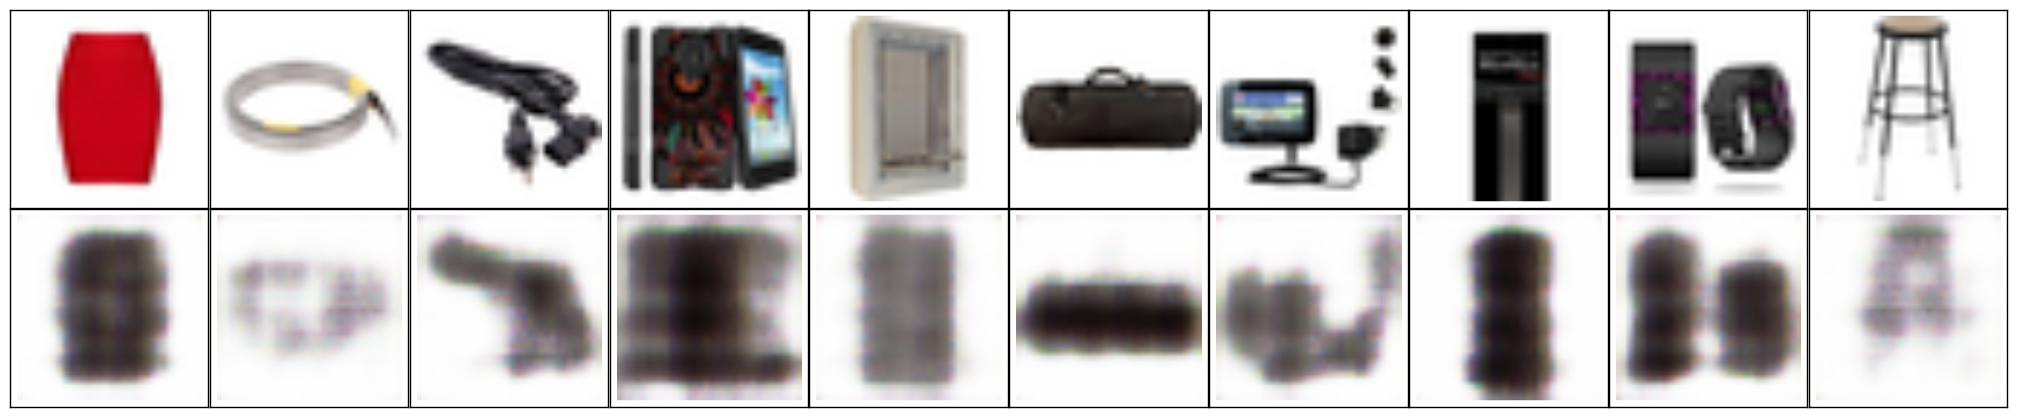

In [22]:
loaded_graph=tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader=tf.train.import_meta_graph('./encode_model.meta')
    loader.restore(sess,tf.train.latest_checkpoint('./'))
    inputs_=loaded_graph.get_tensor_by_name('Placeholder:0')
    recon=loaded_graph.get_tensor_by_name('decoder/recon:0')
    batch_x = get_batch(configfiles, 6, batch_size=10) 
    show_reconstructed(sess,batch_x,recon)

# Generate Validation data's embeddings

In [24]:
path = '/home/Documents/valid_set/'

configfiles = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(path)
    for f in fnmatch.filter(files, '*.jpeg')]

In [25]:
def valid_get_batch(configfiles):    
    
       # print(image_name_list_batch)
    import PIL.Image    
    
    img_data_list = []
    for image_name in configfiles:
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        img = PIL.Image.open(image_name)
        img = resize(img)
        img_data_list += [rescale( img2array(img) )]
        
    X_batch = np.asanyarray(img_data_list)
    return (X_batch)

In [27]:
loaded_graph=tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader=tf.train.import_meta_graph('./encode_model.meta')
    loader.restore(sess,tf.train.latest_checkpoint('./'))
    
    #print([[n.name for n in tf.get_default_graph().as_graph_def().node if 'de-convo' in n.name]])
    inputs_=loaded_graph.get_tensor_by_name('Placeholder:0')
    encoding=loaded_graph.get_tensor_by_name('encoding/encoding/AvgPool:0')
    recon=loaded_graph.get_tensor_by_name('decoder/recon:0')
    
    batch_x=valid_get_batch(configfiles)
    validations=sess.run(encoding,feed_dict={inputs_:batch_x}) #50,8,8,4
    validations=validations.reshape(-1,8*8*4)
    #show_reconstructed(sess,batch_x,recon)

INFO:tensorflow:Restoring parameters from ./encode_model


# Model Testing on Dev set

## calculate L2 distance on encodings of two images

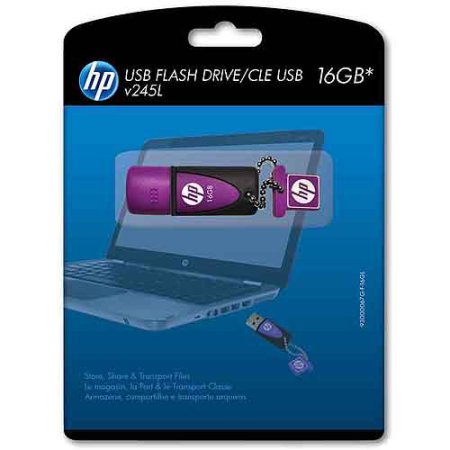

In [29]:
Image(filename='blue1.jpeg') 

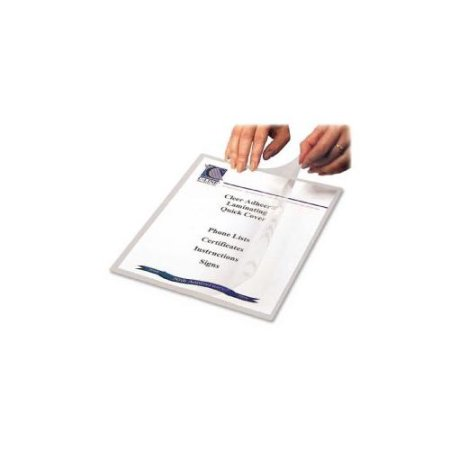

In [30]:
Image(filename='card.jpeg') 

In [31]:
np.linalg.norm(validations[0]-validations[15])

6.123908

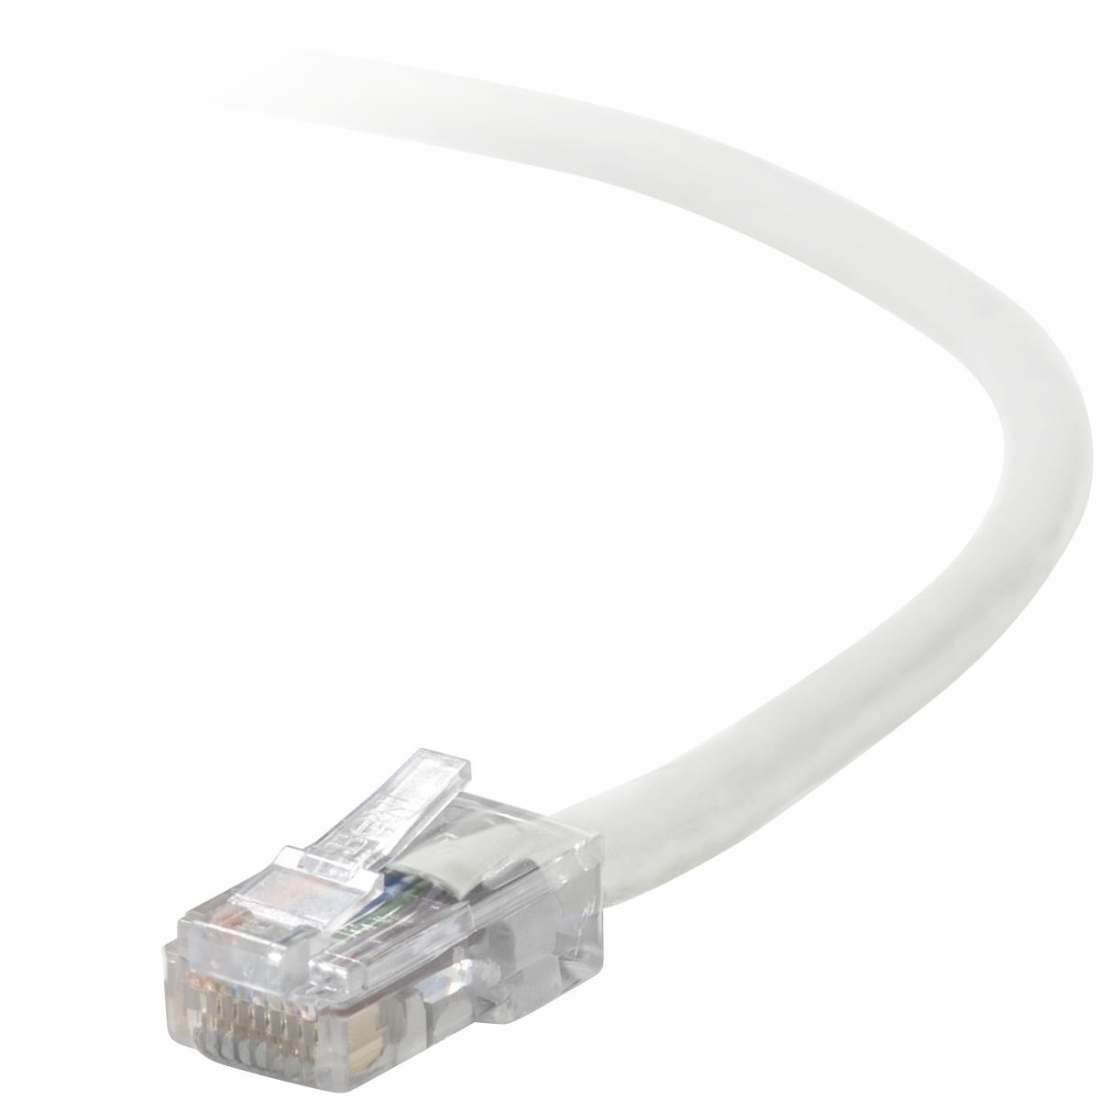

In [32]:
Image(filename='lan_cable.jpeg') 

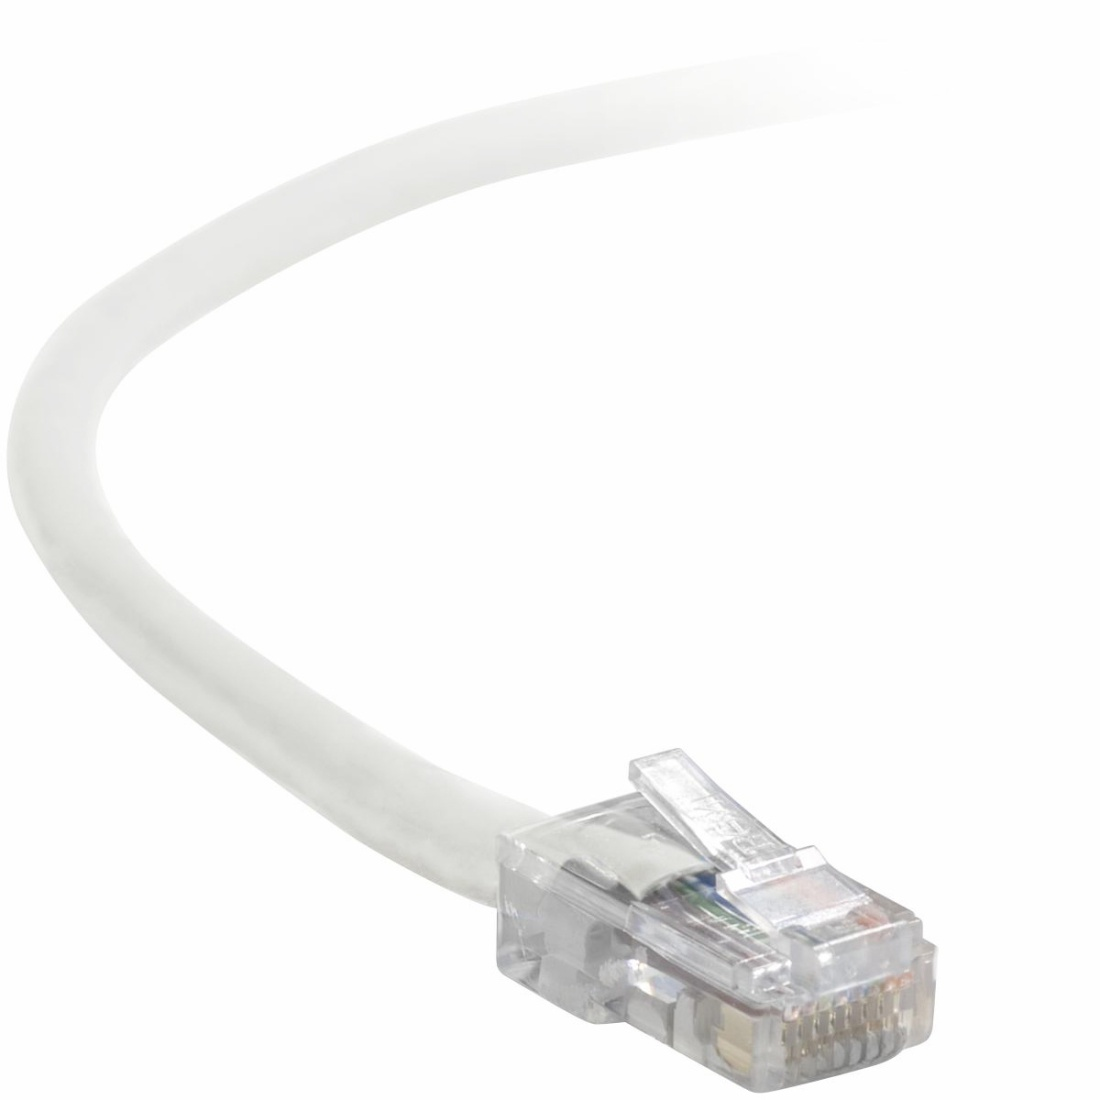

In [33]:
Image(filename='lan_flip.jpeg') 

In [34]:
np.linalg.norm(validations[20]-validations[36])

0.95752871

# Compare results with Phash

In [36]:
img = PIL.Image.open('lan_cable.jpeg')
image1 = imagehash.phash(img)

In [37]:
img = PIL.Image.open('lan_flip.jpeg')
image2 = imagehash.phash(img)

In [38]:
image1-image2

32

# Kmeans clustering for optimization

In [39]:
kmeans=KMeans(n_clusters=20, n_jobs=-1)

In [41]:
kmeans_fit = kmeans.fit(myArray) #1 gb of ram to store 1 million embeddings. 1 million * 256 * 4 byte(float)

In [42]:
cluster_centers = kmeans.cluster_centers_ #these are cluster centers from kmeans

In [43]:
cluster_centers.shape

(20, 256)

In [45]:
pred = kmeans.predict(myArray)

In [46]:
pred.shape

(3397,)

In [48]:
with open('kmeans_model.pkl', 'wb') as f:
     pickle.dump(kmeans_fit, f)

In [49]:
pkl = open('kmeans_model.pkl', 'rb')
kmeans_pred = pickle.load(pkl)   

In [50]:
cluster_centers = kmeans_pred.cluster_centers_ 

In [51]:
pred = kmeans_pred.predict(myArray)

In [54]:
for i in range(20):
    index = np.where(pred == i)
    np.array(cluster_centers[i]).dump(open('cluster_center[%s].npy' % i, 'wb'))
    np.array(myArray[index]).dump(open('binary_encodings[%s].npy' % i, 'wb'))

# Predict clusters for each image encoding from the Dev set

In [55]:
valid_pred = kmeans_pred.predict(validations)

In [56]:
valid_pred

array([18,  7, 10,  8,  7, 12,  5,  5,  3,  3, 10,  1, 17,  2,  8, 10,  7,
       16,  8,  9, 10, 10,  1,  5, 16,  6,  2, 12, 18,  5,  5,  3,  9,  2,
       12,  9, 10,  7,  7, 10,  9,  9, 16,  8,  9,  6, 14,  9, 16,  8, 10,
        0, 16,  2,  6, 12,  8,  3,  9,  7,  3,  3,  7,  2, 16,  2, 10,  6,
        7,  6,  8,  8, 10,  3,  9,  7,  2,  6,  5,  5,  9, 12,  6,  6], dtype=int32)

In [57]:
valid_pred.shape

(84,)